### Likelihood different levels
This notebook investigates the likelihood functions for the different model approximations $\Phi_h$.
Here $\Phi_h$ is the forward map, that maps the stiffness values $\theta \in \mathbb{R}^{64}$ to the solution of the Poisson equation, which is given as vector in $\mathbb{R}^{169}$ after applying a measurement operator.
As convention we use $x = \exp(\theta)$ , so $x$ are arbitrary values in $\mathbb{R}^{64}$ while $\theta$ are always assumed to be possitive to give a proper physical interpretation of stiffness. 

We consider the following cases $h=1/16$ and $h=1/32$. With the following Likelihood:

$\mathcal{L}_h(\hat{z}|x) = \prod_{k=0}^{168}  \exp(-\frac{(\hat{z}_k-\Phi _h(x)_k)^2}{2\sigma^2})$

In [1]:
# imports
import numpy as np
import matplotlib.pyplot as plt
import tinyDA as tda
import ray

from forward_model import Forward_Model


In [2]:
# define class for Likelihood 

class Likelihood():
    """ 
    Likelihood

    Args:
            data (array): measurements
            sigma (float): standard deviation of distribution
            forward_model (callable): Forward model 
    """
    def __init__(self, data, sigma, forward_model):
        self.data = data
        self.sigma = sigma
        self.forward_model = forward_model
    
    def __call__(self, x):
        misfit = ((self.data - self.forward_model(x))**2)/(2*self.sigma**2)
        e = -misfit.sum()
        return e

In [3]:
my_model_l0 = Forward_Model(h=1 / 8, inputs_positive=False)
my_model_l1 = Forward_Model(h=1 / 16, inputs_positive=False)
my_model_l2 = Forward_Model(h=1 / 32, inputs_positive=False)

sig_l2 = 0.05
sig_l1 = 0.05
sig_l0 = 0.05

# load measurements
z_measurement = np.loadtxt("z_hat.txt")

# define the loglikelihood functions for the levels
cov_likelihood_l2 = sig_l2**2 * np.eye(z_measurement.size)
cov_likelihood_l1 = sig_l1**2 * np.eye(z_measurement.size)
cov_likelihood_l0 = sig_l0**2 * np.eye(z_measurement.size)

my_loglike_l2 = tda.GaussianLogLike(z_measurement, cov_likelihood_l2)
my_loglike_l1 = tda.GaussianLogLike(z_measurement, cov_likelihood_l1)
my_loglike_l1 = tda.GaussianLogLike(z_measurement, cov_likelihood_l0)

L_l2 = Likelihood(z_measurement, sig_l2, my_model_l2) # this is the Likelihood function for FE discretization with h=1/32
L_l1 = Likelihood(z_measurement, sig_l1, my_model_l1) # this is the Likelihood function for FE discretization with h=1/16
L_l0 = Likelihood(z_measurement, sig_l0, my_model_l0) # this is the Likelihood function for FE discretization with h=1/16

Negative inputs to forward model are allowed; exp(input) is passed to the model.
Negative inputs to forward model are allowed; exp(input) is passed to the model.
Negative inputs to forward model are allowed; exp(input) is passed to the model.


In [4]:
# define one and two dimensional maps to plot highdimensional Likelihood

def projection_1D(theta_1, component_idx, Likeli):
    dim = theta_1.size
    theta = np.zeros((64, dim)) #fix remainding coordinates at 0
    theta[component_idx, :] = theta_1
    output = []
    for i in range(dim):
        output.append(Likeli(theta[:,i]))
    return output

def projection_2D(theta_1, theta_2, component_idxs, Likeli):
    dim = theta_1.shape[0]
    theta = np.zeros((64,dim,dim)) # fix remainding coordinates at 0
    theta[component_idxs[0],:,:] = theta_1
    theta[component_idxs[1],:,:] = theta_2
    output = np.zeros((dim,dim))
    for i in range(dim):
        for j in range(dim):
            output[i,j] = Likeli(theta[:,i,j])
    
    return output
    
    


### 1D Likelihood
The Likelihood is a mapping from $\mathbb{R}^{64} \mapsto \mathbb{R} $, therefore we plot the 1 dimensional projection where all arguments are fixed at $1$ except for one component. Furthermore not directly the Likelihood is drawn but its logarithm:

$ \theta_i \mapsto \log \mathcal{L}_h(\hat{z}| \theta = [1,...,\theta_i,...,1]) $

In [5]:
# evaluate 1D Likelihood using Ray for parallel computing

theta_idx = [0,9,27,36,54,63] # indices to plot
x = np.linspace(-4,4,1000) # 1D domain
theta = np.sqrt(2)*np.random.randn(64, x.shape[0])

Likeli_remote = ray.remote(projection_1D)

ray.init()
future_L2 = [Likeli_remote.remote(x, th, L_l2) for th in theta_idx]
future_L1 = [Likeli_remote.remote(x, th,  L_l1) for th in theta_idx]
future_L0 = [Likeli_remote.remote(x, th, L_l0) for th in theta_idx]

Likeli_L0_values_1D = ray.get(future_L0)
Likeli_L1_values_1D = ray.get(future_L1)
Likeli_L2_values_1D = ray.get(future_L2)

ray.shutdown()


2024-02-15 14:07:47,852	INFO worker.py:1612 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 


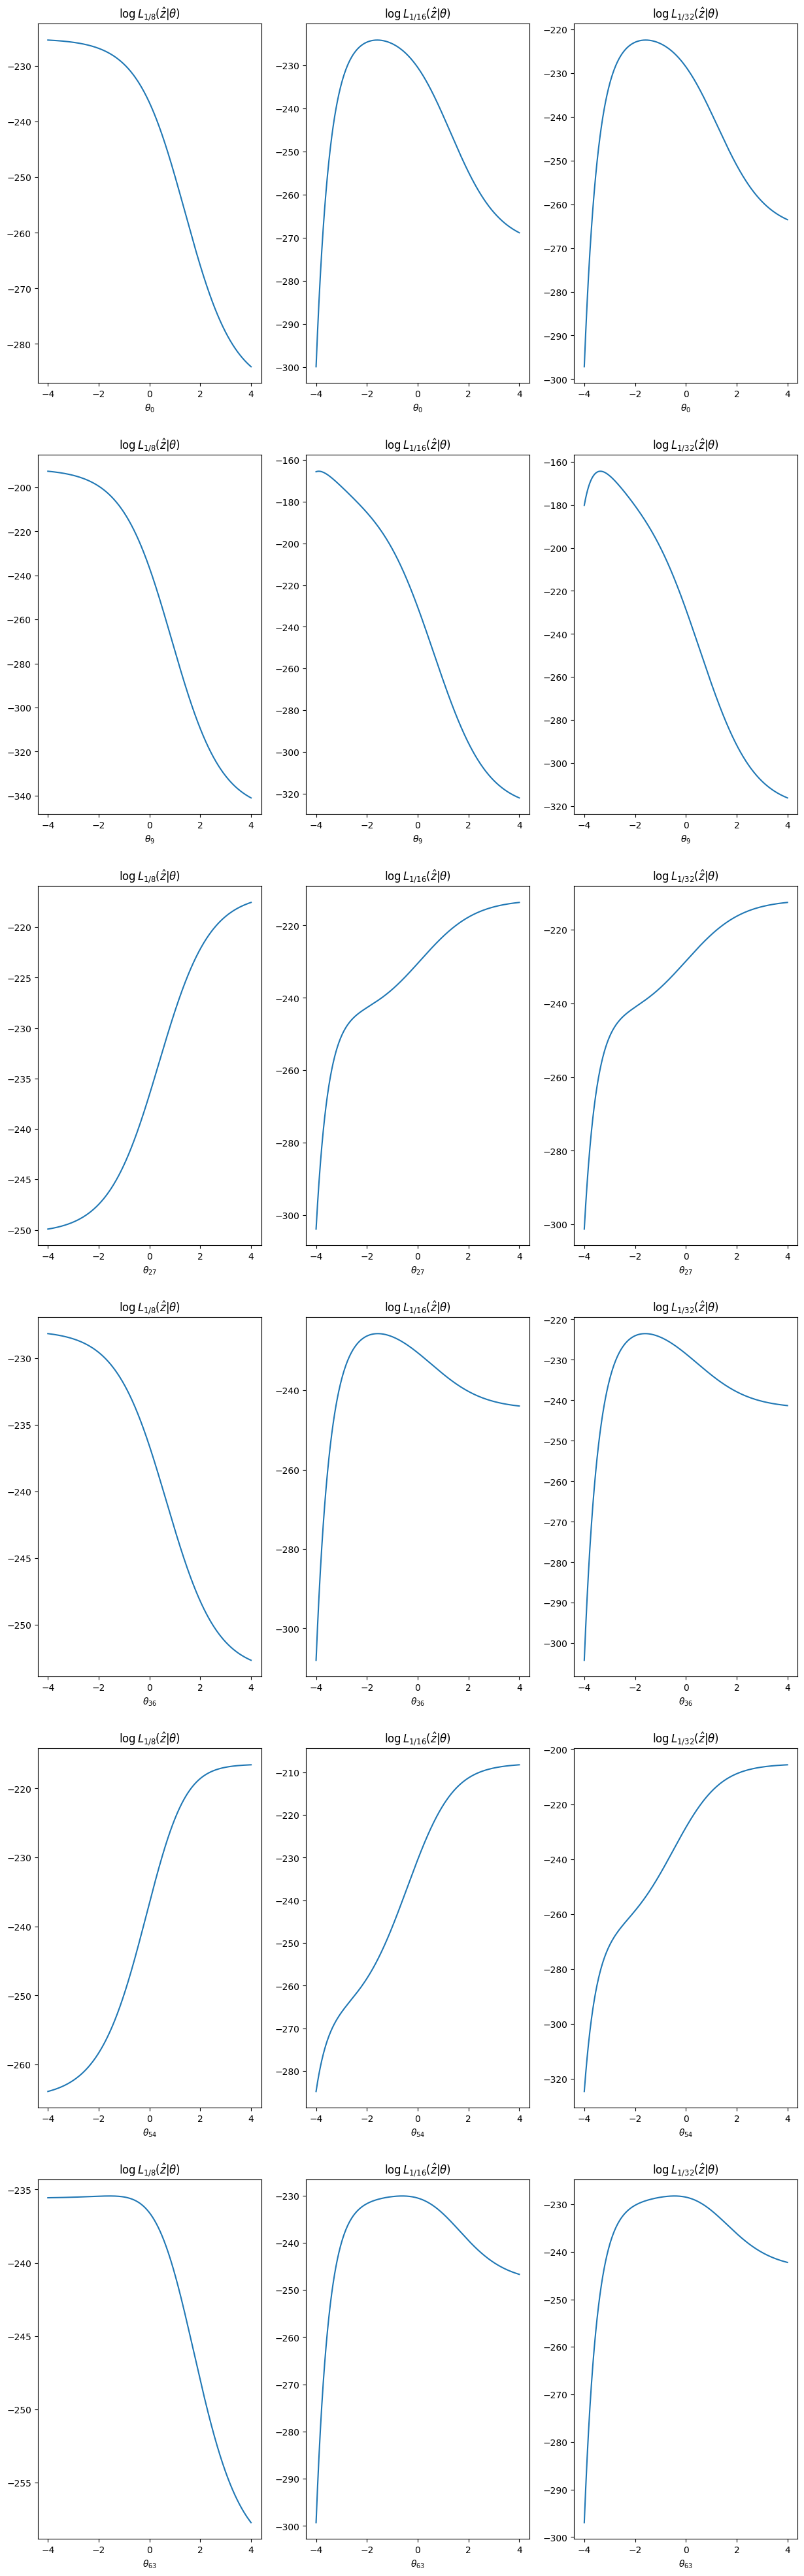

In [6]:
# plot Likelihood values 

fig, axs = plt.subplots(nrows=int(len(theta_idx)), ncols=3, figsize=(15,50))

for i, th in enumerate(theta_idx):

    axs[i,0].plot(x, Likeli_L0_values_1D[i])
    axs[i,0].set_xlabel(r'$\theta_{%d}$'%th)
    axs[i,0].set_title(r'$\log L_{1/8}(\hat{z}|\theta)$')

    axs[i,1].plot(x, Likeli_L1_values_1D[i])
    axs[i,1].set_xlabel(r'$\theta_{%d}$'%th)
    axs[i,1].set_title(r'$\log L_{1/16}(\hat{z}|\theta)$')

    axs[i,2].plot(x, Likeli_L2_values_1D[i])
    axs[i,2].set_xlabel(r'$\theta_{%d}$'%th)
    axs[i,2].set_title(r'$\log L_{1/32}(\hat{z}|\theta)$')


### 2D Likelihood

Here we plot the 2 dimensional projection where all arguments are fixed at $1$ except for two components. Furthermore not directly the Likelihood is drawn but its logarithm:

$ [\theta_i, \theta_j] \mapsto \log \mathcal{L}_h(\hat{z}| \theta = [1,...,\theta_i,...,\theta_j,...,1]) $

In [7]:
theta_idx = [[0,9],[9,10],[27,36],[13,14],[45,54],[49,50]] # theta pairs to plot


In [8]:
# evaluate 2D Likelihood using Ray for parallel computing

theta_idx = [[0,9],[9,10],[27,36],[13,14],[45,54],[49,50]] # theta pairs to plot
X,Y  = np.meshgrid(np.linspace(-4,4,100), np.linspace(-4, 4,100)) # domain 
dim = X.shape[0]
theta = np.sqrt(2)*np.random.randn(64,dim,dim)

Likeli_remote = ray.remote(projection_2D)

ray.init()
future_L2 = [Likeli_remote.remote(X,Y, th, L_l2) for th in theta_idx]
future_L1 = [Likeli_remote.remote(X,Y, th, L_l1) for th in theta_idx]
future_L0 = [Likeli_remote.remote(X,Y, th, L_l0) for th in theta_idx]

Likeli_L0_values = ray.get(future_L0)
Likeli_L1_values = ray.get(future_L1)
Likeli_L2_values = ray.get(future_L2)

ray.shutdown()

2024-02-15 14:09:14,326	INFO worker.py:1612 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 


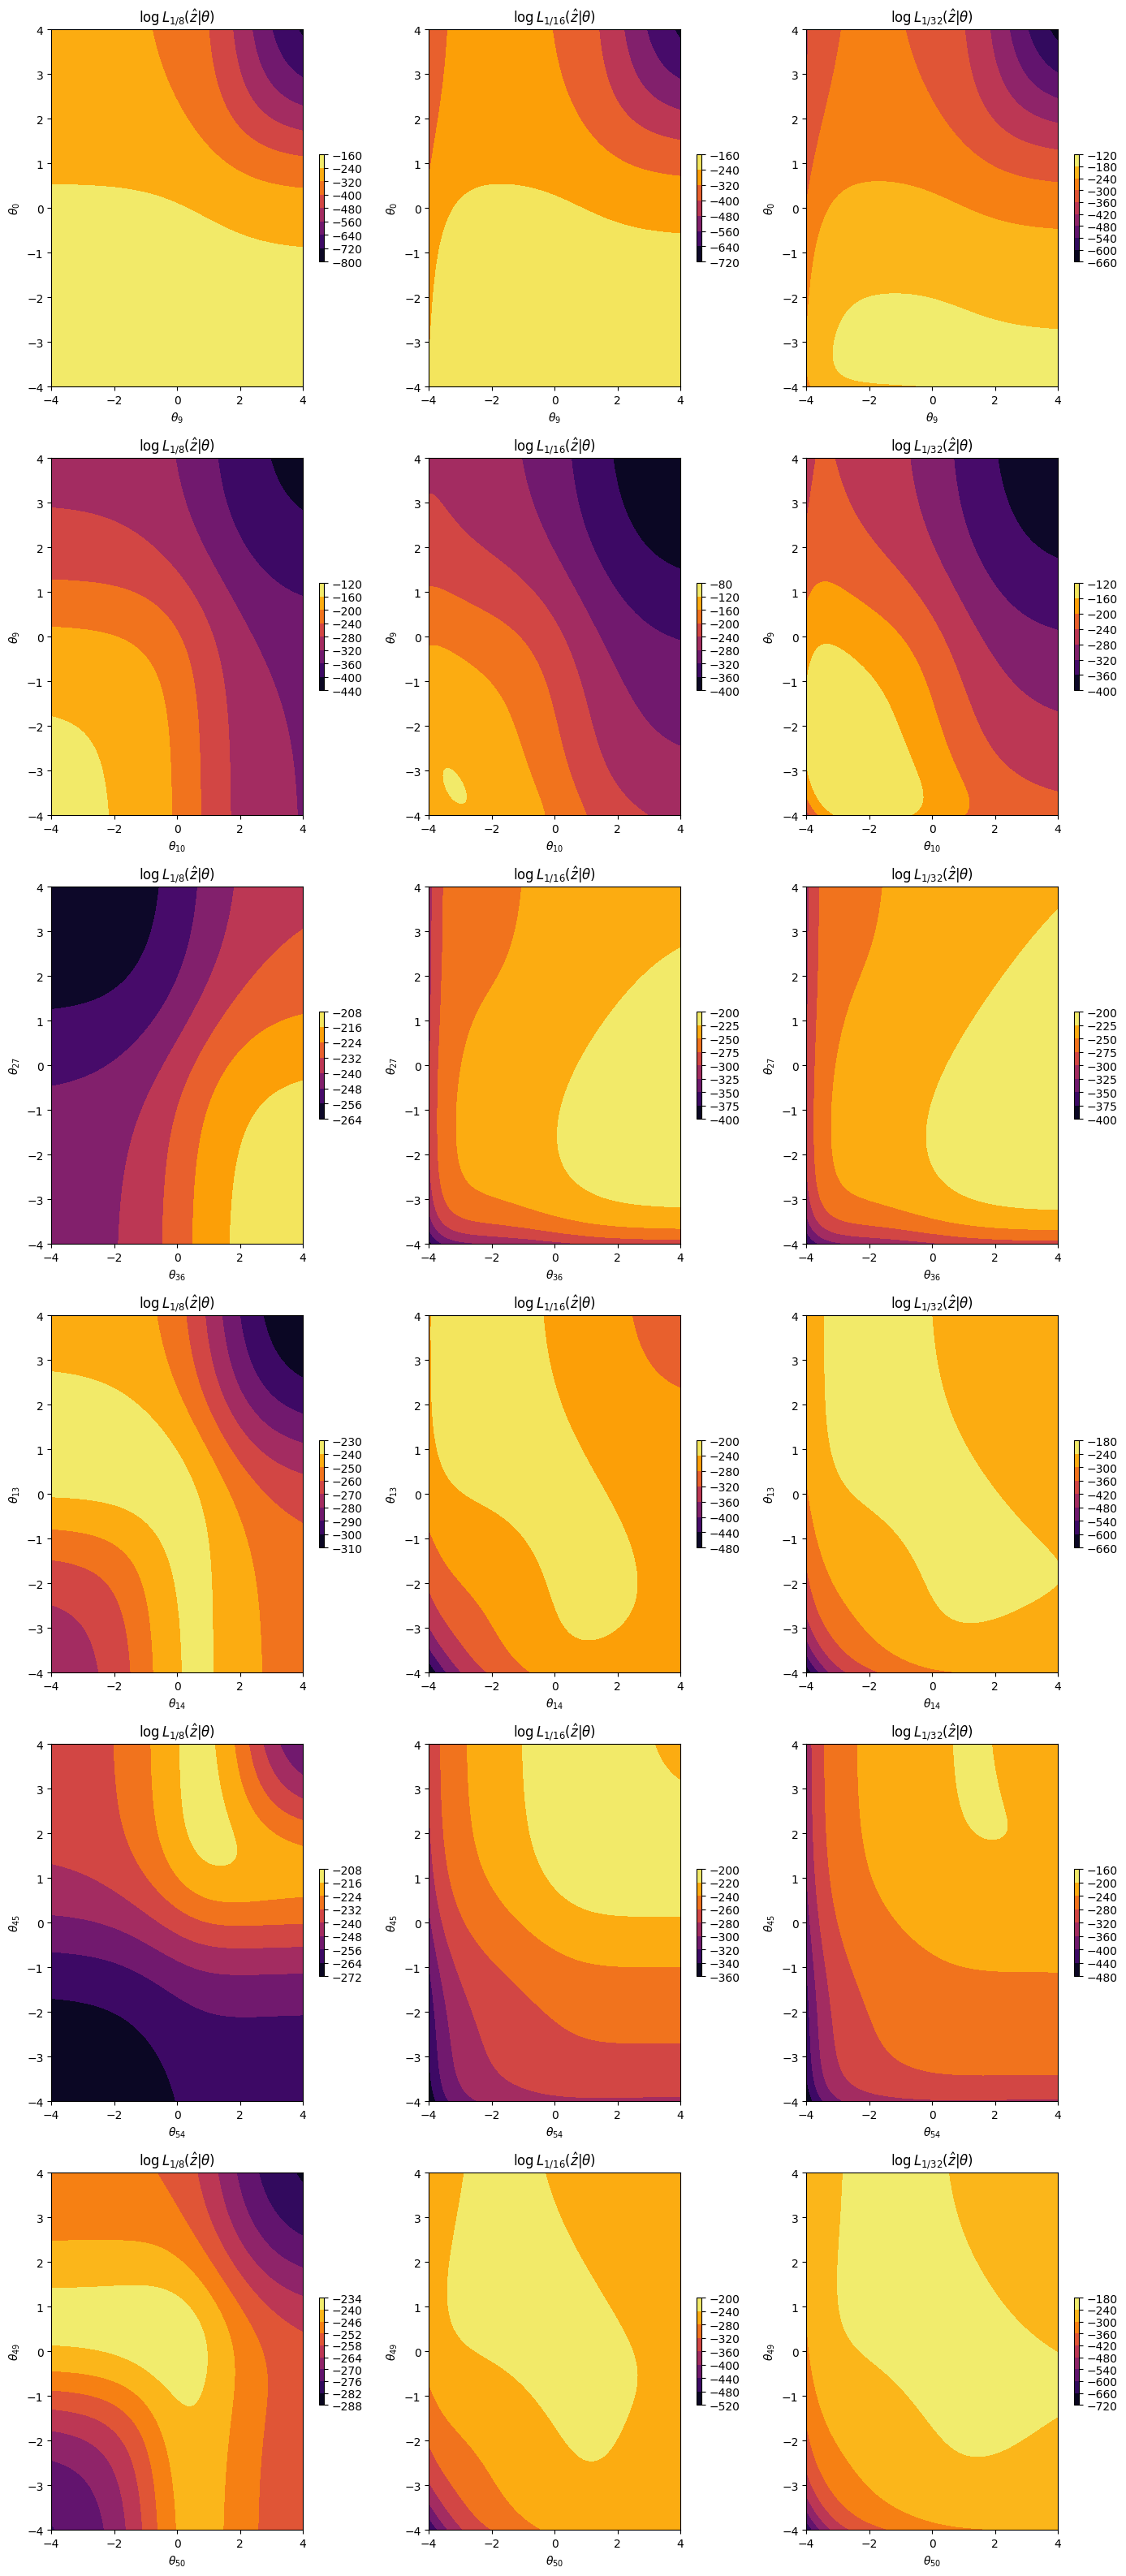

In [9]:
# plot 2D

fig, axs = plt.subplots(nrows= int(len(theta_idx)),ncols=3, figsize=(17,40))

for i, th in enumerate(theta_idx):
    im1  = axs[i,0].contourf(X,Y,Likeli_L0_values[i], cmap='inferno')
    axs[i,0].set_ylabel(r'$\theta_{%d}$'%th[0])
    axs[i,0].set_xlabel(r'$\theta_{%d}$'%th[1])
    axs[i,0].set_title(r'$\log L_{1/8}(\hat{z}|\theta)$')
    fig.colorbar(im1,ax=axs[i,0], shrink=0.3)

    im1  = axs[i,1].contourf(X,Y,Likeli_L1_values[i], cmap='inferno')
    axs[i,1].set_ylabel(r'$\theta_{%d}$'%th[0])
    axs[i,1].set_xlabel(r'$\theta_{%d}$'%th[1])
    axs[i,1].set_title(r'$\log L_{1/16}(\hat{z}|\theta)$')
    fig.colorbar(im1,ax=axs[i,1], shrink=0.3)

    im2 = axs[i,2].contourf(X,Y,Likeli_L2_values[i], cmap='inferno')
    axs[i,2].set_ylabel(r'$\theta_{%d}$'%th[0])
    axs[i,2].set_xlabel(r'$\theta_{%d}$'%th[1])
    axs[i,2].set_title(r'$\log L_{1/32}(\hat{z}|\theta)$')
    fig.colorbar(im2, ax=axs[i,2], shrink=0.3)
